In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

Could not import BEM module. Please do so manually.


# Before cycling the fridge 

In [10]:
with h5py.File("/Volumes/slab/_Data/170424 - M018V6 Filters Breton cooldown/data/170424/192153_filter_7windings_20fingers/filter_7windings_20fingers.h5", "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f_filter = fpoints[0]
mag_filter = mags[0]

with h5py.File("/Volumes/slab/_Data/170424 - M018V6 Filters Breton cooldown/data/170424/193226_through_measurement/through_measurement.h5", "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f_bg = fpoints[0]
mag_bg = mags[0]

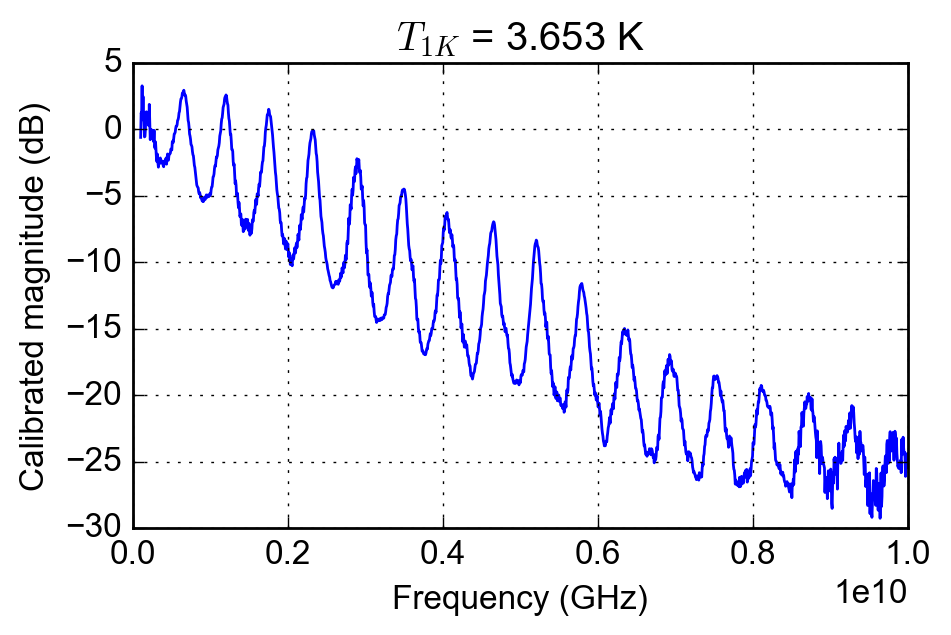

In [19]:
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
#plt.plot(f_filter, mag_filter)
#plt.plot(f_bg, mag_bg)
plt.plot(f_filter, mag_filter-mag_bg)

plt.grid()
plt.xlabel("Frequency (GHz)")
plt.ylabel("Calibrated magnitude (dB)")

plt.title("$T_{1K}$ = %.3f K"%(temperature[0]))

# At base temperature

In [21]:
with h5py.File("/Volumes/slab-1/_Data/170424 - M018V6 Filters Breton cooldown/data/170424/204919_filter_7windings_20fingers/filter_7windings_20fingers.h5", "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f_filter = fpoints[0]
mag_filter = mags[0]

with h5py.File("/Volumes/slab-1/_Data/170424 - M018V6 Filters Breton cooldown/data/170424/204629_through_measurement/through_measurement.h5", "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f_bg = fpoints[0]
mag_bg = mags[0]

The following function comes from a notebook from September 27th 2016. It calculates the transmission spectrum through the bias tee (L-C filter)

1.59154943092
Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  =======================  =====================
Parameter             Value                    Std
===========  =======================  =====================
a0             -0.5663250528961651     0.16662206055243134
a1           -2.8165566397681383e-09  2.871078565385651e-11
===========  =======================  =====================


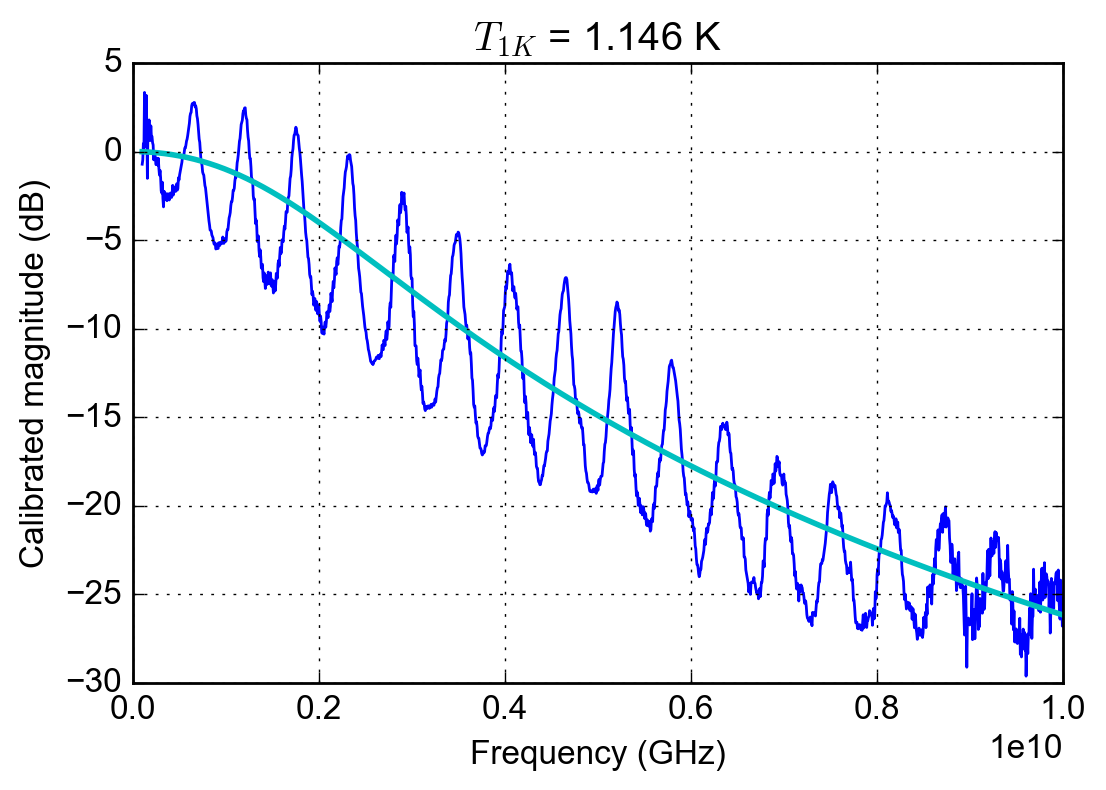

In [41]:
L = 2.5E-9 # in Henry
C = 0.004E-9 # in Farad
Z0 = 50.

def S21(f, L, C, Z0):
    omega = 2*np.pi*f
    return np.abs(2/(2-omega**2*L*C+1j*omega*(L/Z0 + C*Z0)))

print(1/(2*np.pi*np.sqrt(L*C)*1E9))

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
#plt.plot(f_filter, mag_filter)
#plt.plot(f_bg, mag_bg)
plt.plot(f_filter, mag_filter-mag_bg)

fr, ferr = kfit.fit_poly(f_filter, mag_filter-mag_bg, fitparams=[0, -25/1E10])
#plt.plot(f_filter, kfit.polyfunc(f_filter, *fr), '-r', lw=2.0)
plt.plot(f_filter, 20*np.log10(S21(f_filter, L, C, Z0)), '-c', lw=2.0)

plt.grid()
plt.xlabel("Frequency (GHz)")
plt.ylabel("Calibrated magnitude (dB)")

plt.title("$T_{1K}$ = %.3f K"%(temperature[0]))
#common.save_figure(fig, save_path=r"/Volumes/slab-1/_Data/170424 - M018V6 Filters Breton cooldown/data/170424/204919_filter_7windings_20fingers")

# Batch 3 

In [42]:
fn = r"/Volumes/slab/_Data/170424 - M018V6 Filters and Testing Breton/data/170426/133524_batch3_pinch_n_guards_open/batch3_pinch_n_guards_open.h5"

with h5py.File(fn, "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f = fpoints[0]
mag = mags[0]

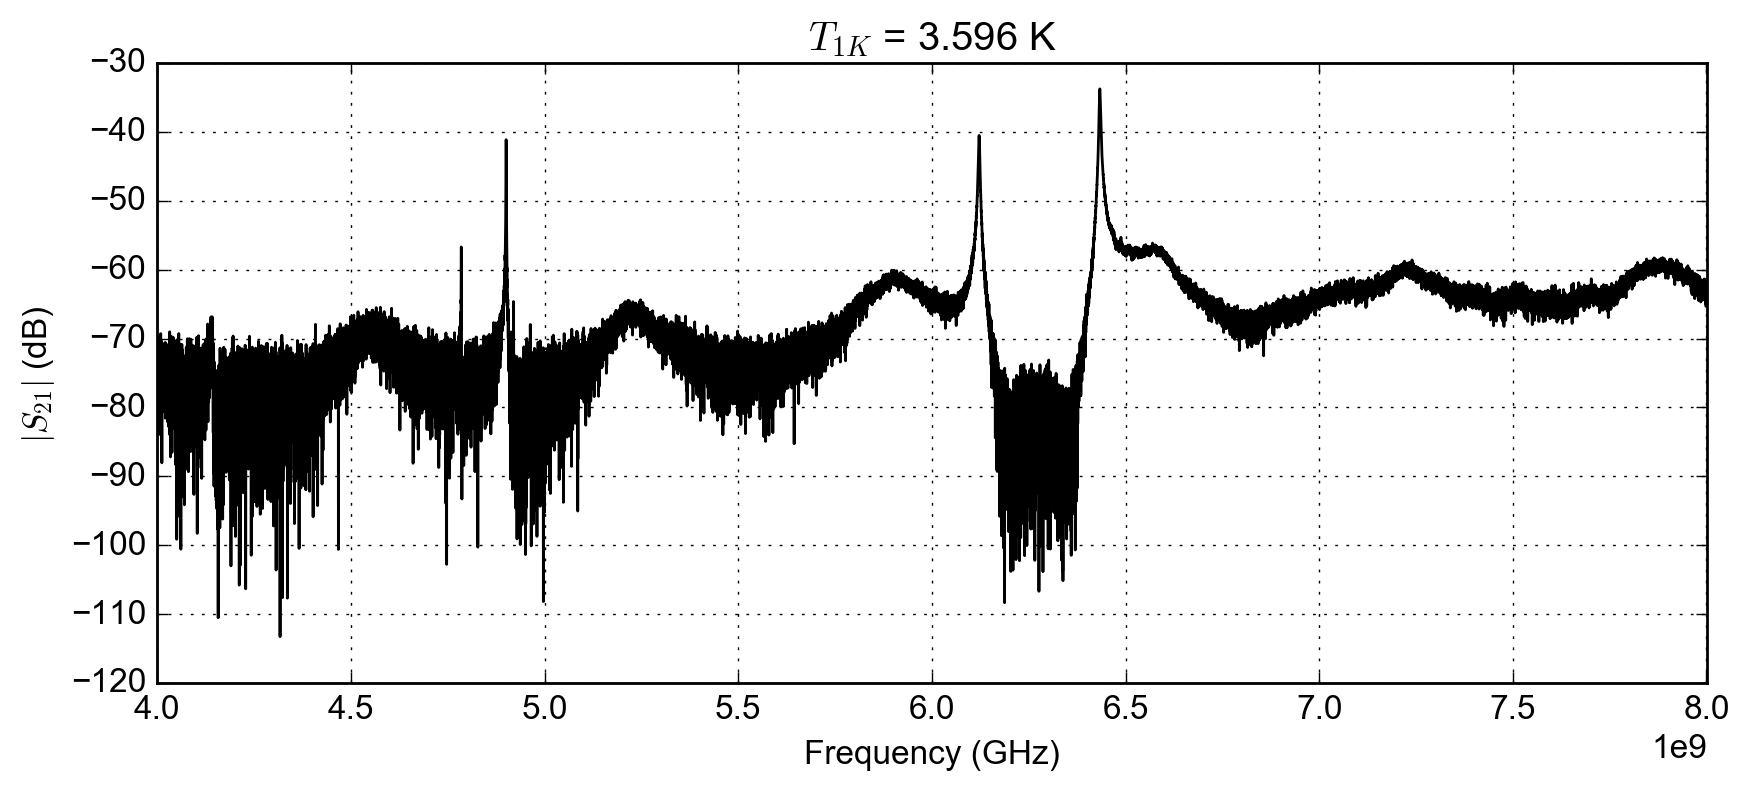

In [43]:
fig = plt.figure(figsize=(10.,4.))
common.configure_axes(12)
plt.plot(f, mag, '-k')

plt.grid()
plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{21}|$ (dB)")
plt.xlim(f[0], f[-1])

plt.title("$T_{1K}$ = %.3f K"%(temperature[0]))

===========  =====================  =====================
Parameter            Value                   Std
===========  =====================  =====================
Offset       2.017558005207498e-11  2.675634723375496e-11
Amplitude    7.728207430613668e-08  2.157871867773781e-10
f0             4900599306.548388      891.9038076762023
HWHM          -319451.4377954842     1328.0793167335946
===========  =====================  =====================
-7670.33534168
===========  =====================  ======================
Parameter            Value                   Std
===========  =====================  ======================
Offset       2.914619030195331e-11  8.703374640959258e-12
Amplitude    2.013725942544767e-09  5.3987535788631377e-11
f0             4784746374.58706       6495.072841123862
HWHM           242469.4886516331      9951.296546558442
===========  =====================  ======================
9866.69787031
===========  ======================  ======================
Param

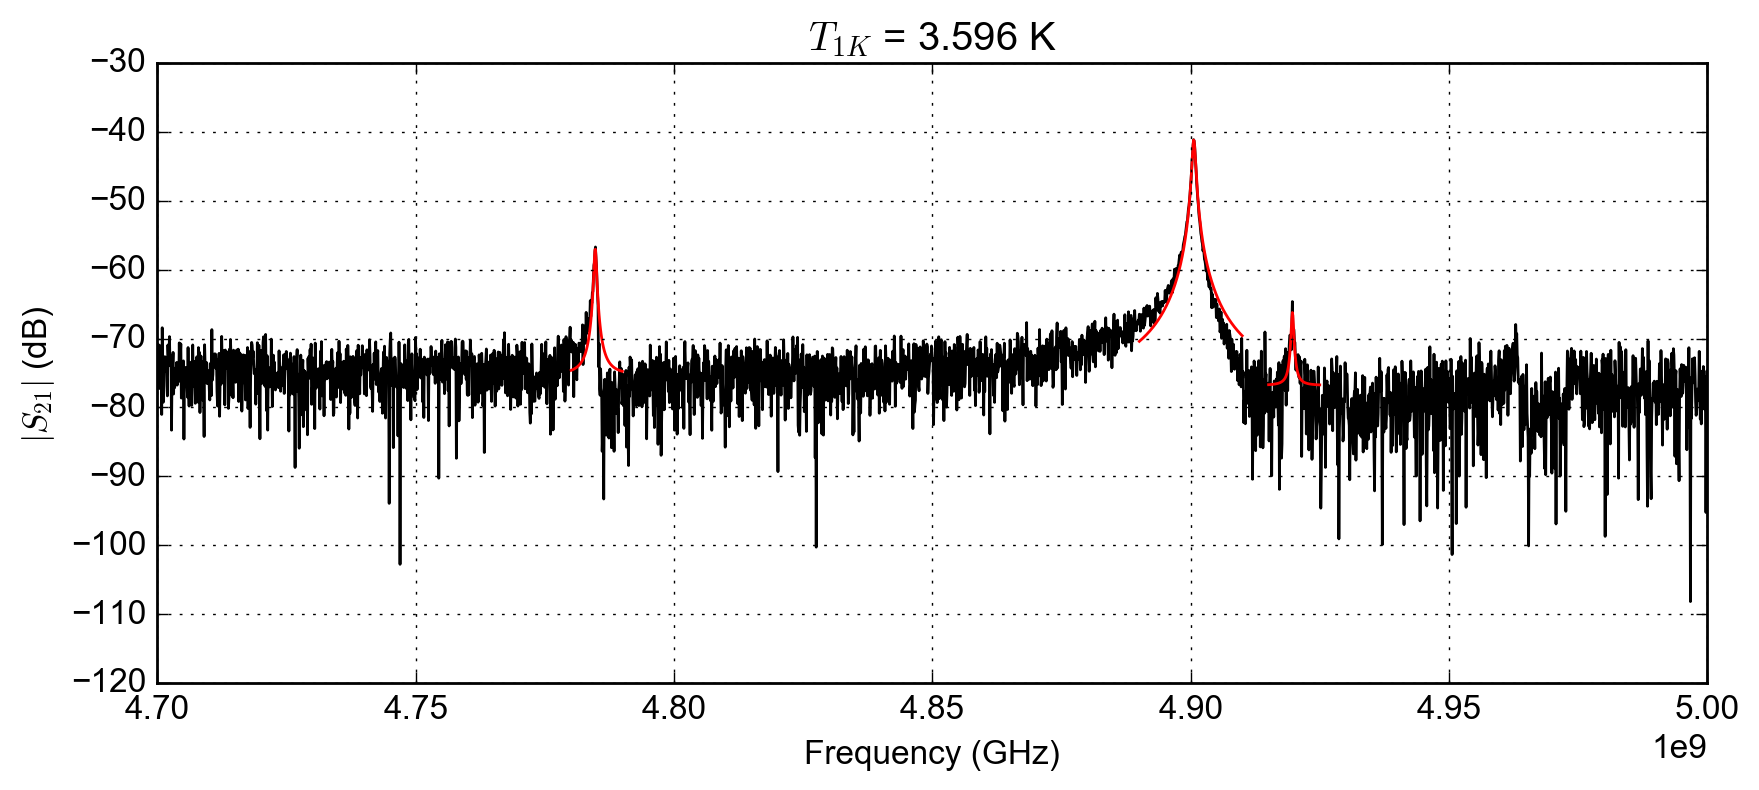

In [44]:
fig = plt.figure(figsize=(10.,4.))
common.configure_axes(12)
plt.plot(f, mag, '-k')

domain = (4.90E9-10E6, 4.90E9+10E6)
f_fit, mag_fit = kfit.selectdomain(xdata=f, ydata=mag, domain=domain)
fr, ferr = kfit.fit_lor(f_fit, common.dBm_to_W(mag_fit))
plt.plot(f_fit, 10*np.log10(kfit.lorfunc(f_fit, *fr)) + 30, '-r', lw=1.0)
print(fr[2]/(2*fr[3]))

domain=(4.785E9-5E6, 4.785E9+5E6)
f_fit, mag_fit = kfit.selectdomain(xdata=f, ydata=mag, domain=domain)
fr, ferr = kfit.fit_lor(f_fit, common.dBm_to_W(mag_fit))
plt.plot(f_fit, 10*np.log10(kfit.lorfunc(f_fit, *fr)) + 30, '-r', lw=1.0)
print(fr[2]/(2*fr[3]))

domain=(4.92E9-5E6, 4.92E9+5E6)
f_fit, mag_fit = kfit.selectdomain(xdata=f, ydata=mag, domain=domain)
fr, ferr = kfit.fit_lor(f_fit, common.dBm_to_W(mag_fit))
plt.plot(f_fit, 10*np.log10(kfit.lorfunc(f_fit, *fr)) + 30, '-r', lw=1.0)
print(fr[2]/(2*fr[3]))

plt.grid()
plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{21}|$ (dB)")
plt.xlim(4.7E9, 5.0E9)

plt.title("$T_{1K}$ = %.3f K"%(temperature[0]))

In [50]:
fn = r"/Volumes/slab/_Data/170424 - M018V6 Filters and Testing Breton/data/170426/151627_batch3_pinch_n_guards_open/batch3_pinch_n_guards_open.h5"

with h5py.File(fn, "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f = fpoints[0]
mag = mags[0]

===========  ======================  ======================
Parameter            Value                    Std
===========  ======================  ======================
Offset       2.3540234019175734e-10  1.7956944208637084e-08
Amplitude    3.455711872108836e-05   6.199097983783199e-08
f0              6455222867.26924       381.13218289669834
HWHM           213200.87087849103      646.4627115719542
===========  ======================  ======================
15138.8285626


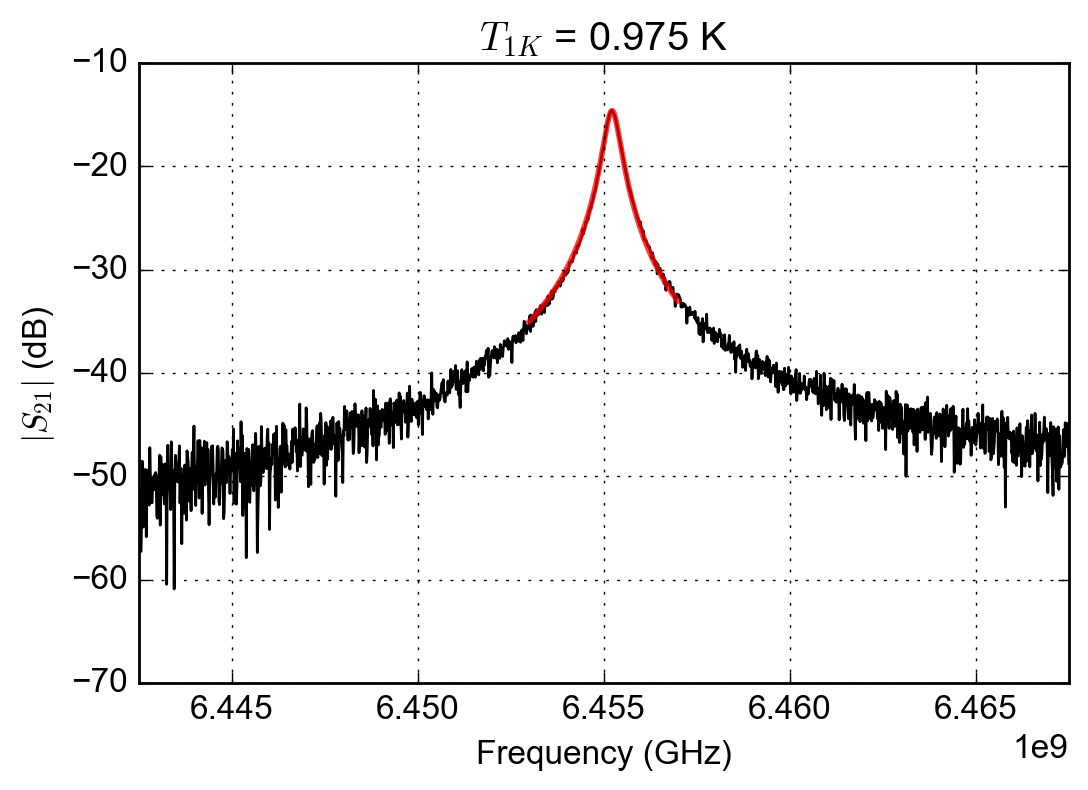

In [51]:
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
plt.plot(f, mag, '-k')

domain=((f[0]+f[-1])/2. - 2E6, (f[0]+f[-1])/2. + 2E6)
f_fit, mag_fit = kfit.selectdomain(xdata=f, ydata=mag, domain=domain)
fr, ferr = kfit.fit_lor(f_fit, common.dBm_to_W(mag_fit), 
                        parambounds=([0, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf]))
plt.plot(f_fit, 10*np.log10(kfit.lorfunc(f_fit, *fr)) + 30, '-r', lw=2.0, alpha=0.75)

print(fr[2]/(2*fr[3]))

plt.grid()
plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{21}|$ (dB)")
plt.xlim(f[0], f[-1])

plt.title("$T_{1K}$ = %.3f K"%(temperature[0]))

# Batch 5 

In [69]:
fn = r"/Volumes/slab/_Data/170424 - M018V6 Filters and Testing Breton/data/170426/145807_batch5_pinch_n_guards_open/batch5_pinch_n_guards_open.h5"

with h5py.File(fn, "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f = fpoints[0]
mag = mags[0]

===========  ======================  ======================
Parameter            Value                    Std
===========  ======================  ======================
Offset       2.7075952828552563e-13  2.617820492584742e-09
Amplitude    9.571350710988446e-06   1.8757976771907468e-08
f0             5319767180.146447       379.5773785122073
HWHM           193705.67046119052      571.5164297603002
===========  ======================  ======================
13731.5731839


(5314000000.0, 5324000000.0)

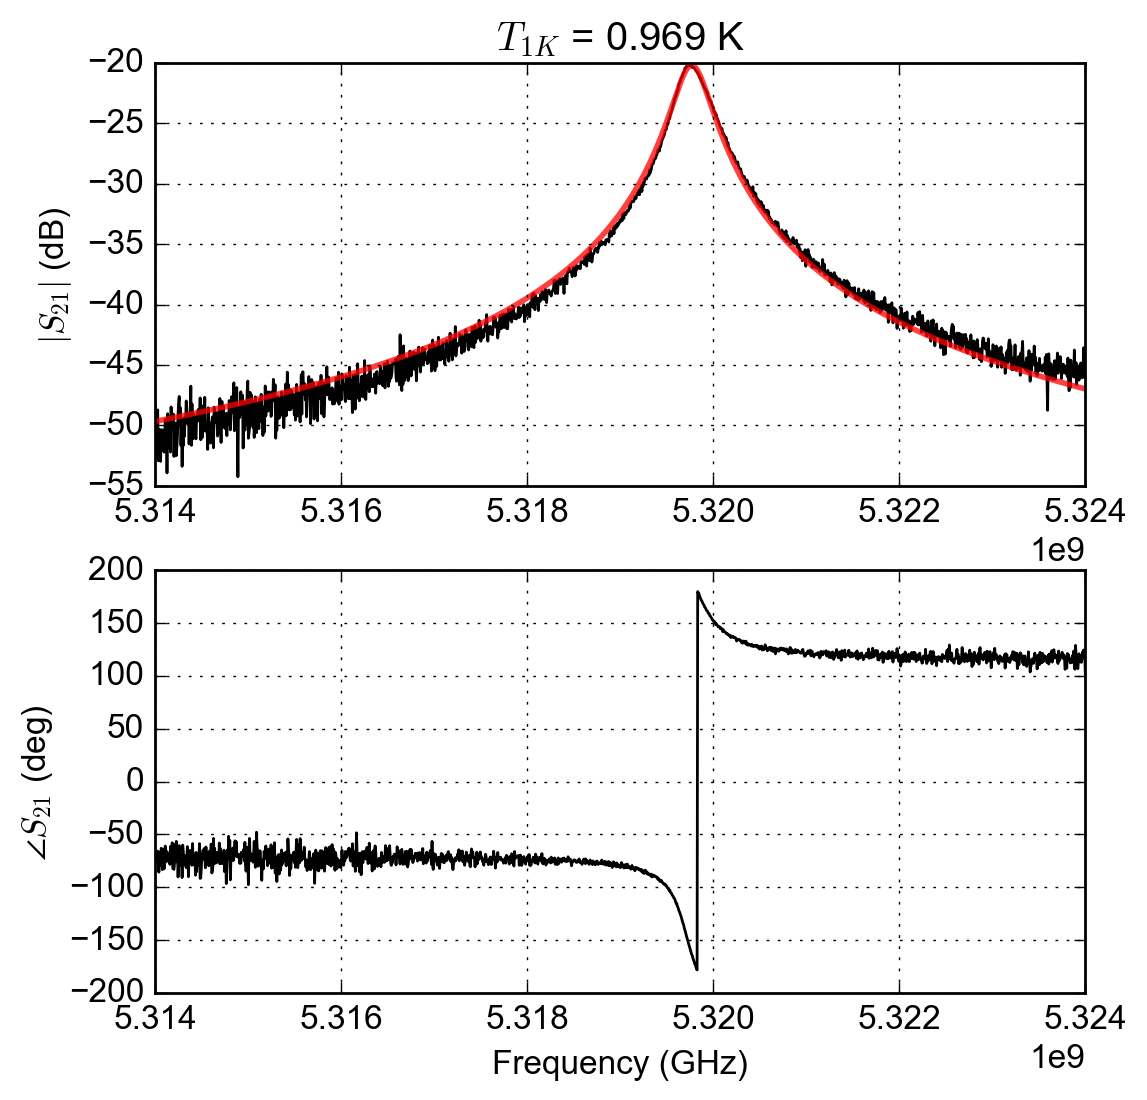

In [72]:
fig = plt.figure(figsize=(6.,6.))
plt.subplot(211)
common.configure_axes(12)
plt.plot(f, mag, '-k')

domain=((f[0]+f[-1])/2. - 25E6, (f[0]+f[-1])/2. + 25E6)
f_fit, mag_fit = kfit.selectdomain(xdata=f, ydata=mag, domain=domain)
fr, ferr = kfit.fit_lor(f_fit, common.dBm_to_W(mag_fit), 
                        parambounds=([0, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf]))
plt.plot(f_fit, 10*np.log10(kfit.lorfunc(f_fit, *fr)) + 30, '-r', lw=2.0, alpha=0.75)

print(fr[2]/(2*fr[3]))

plt.grid()
#plt.xlabel("Frequency (GHz)")
plt.ylabel("$|S_{21}|$ (dB)")
plt.xlim(f[0], f[-1])

plt.title("$T_{1K}$ = %.3f K"%(temperature[0]))

plt.subplot(212)
common.configure_axes(12)
plt.plot(f, phases[0], '-k')
plt.grid()
plt.xlabel("Frequency (GHz)")
plt.ylabel(r"$\angle S_{21}$ (deg)")
plt.xlim(f[0], f[-1])


# Batch 5 : Warm up

In [73]:
fn = r"/Volumes/slab/_Data/170424 - M018V6 Filters and Testing Breton/data/170426/162545_batch5_pinch_n_guards_open_warmup/batch5_pinch_n_guards_open_warmup.h5"

with h5py.File(fn, "r") as f:
    for step in f.keys():
        vars()[step] = f[step][()]
        
f = fpoints
mag = mags

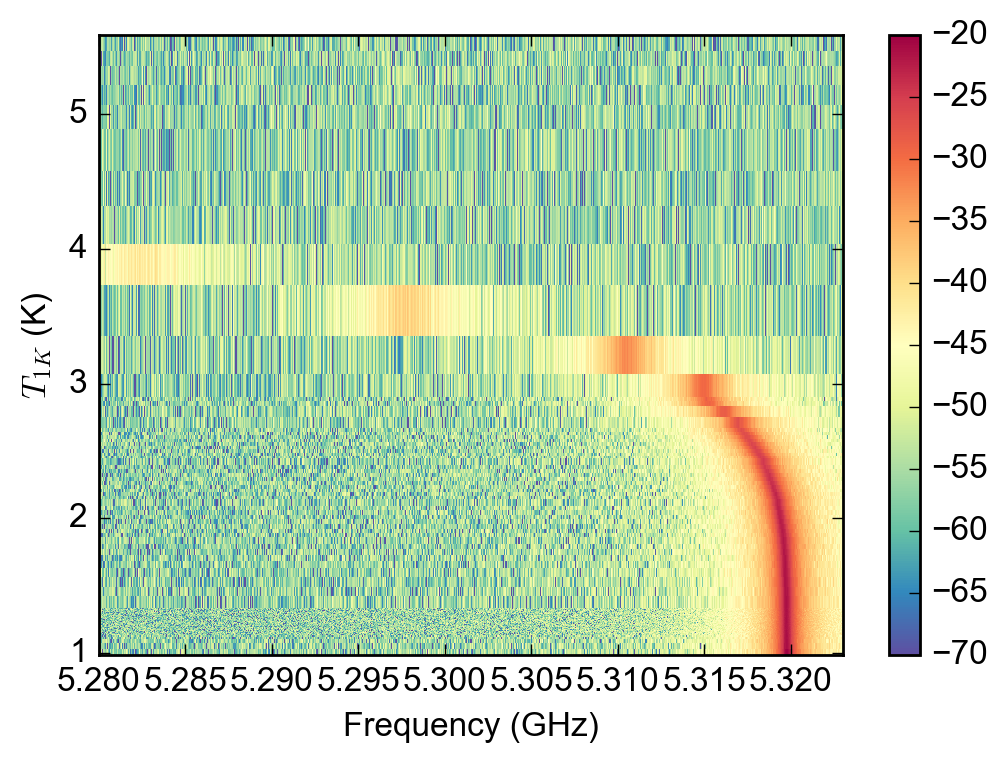

In [90]:
plt.pcolormesh(fpoints/1E9, temperature[:-1], mags, cmap=plt.cm.Spectral_r, vmin=-70, vmax=-20)
plt.colorbar()
plt.xlabel("Frequency (GHz)")
plt.ylim(temperature[0], temperature[-2])
plt.xlim(np.min(fpoints/1E9), np.max(fpoints)/1E9)
plt.ylabel("$T_{1K}$ (K)")

In [102]:
f0s, Qs = list(), list()

for k in tqdm(range(np.shape(mags)[0])):
    center = fpoints[k, np.argmax(mags[k,:])]
    span = 2E6
    fr, ferr = kfit.fit_lor(fpoints[k,:], common.dBm_to_W(mags[k,:]), domain=(center-span/2., center+span/2.), 
                           verbose=False)
    f0s.append(fr[2])
    Qs.append(fr[2]/(2*fr[3]))
    
f0s = np.array(f0s)
Qs = np.array(Qs)

100%|██████████| 124/124 [00:00<00:00, 479.49it/s]


===========================  ====================  =====================
Parameter                           Value                   Std
===========================  ====================  =====================
f0                            5341956154.453778     1845676.9791457115
Kinetic Inductance fraction  0.008188768382158396  0.0006778554056140776
Tc                            4.178858218413239     0.03390668045572157
===========================  ====================  =====================


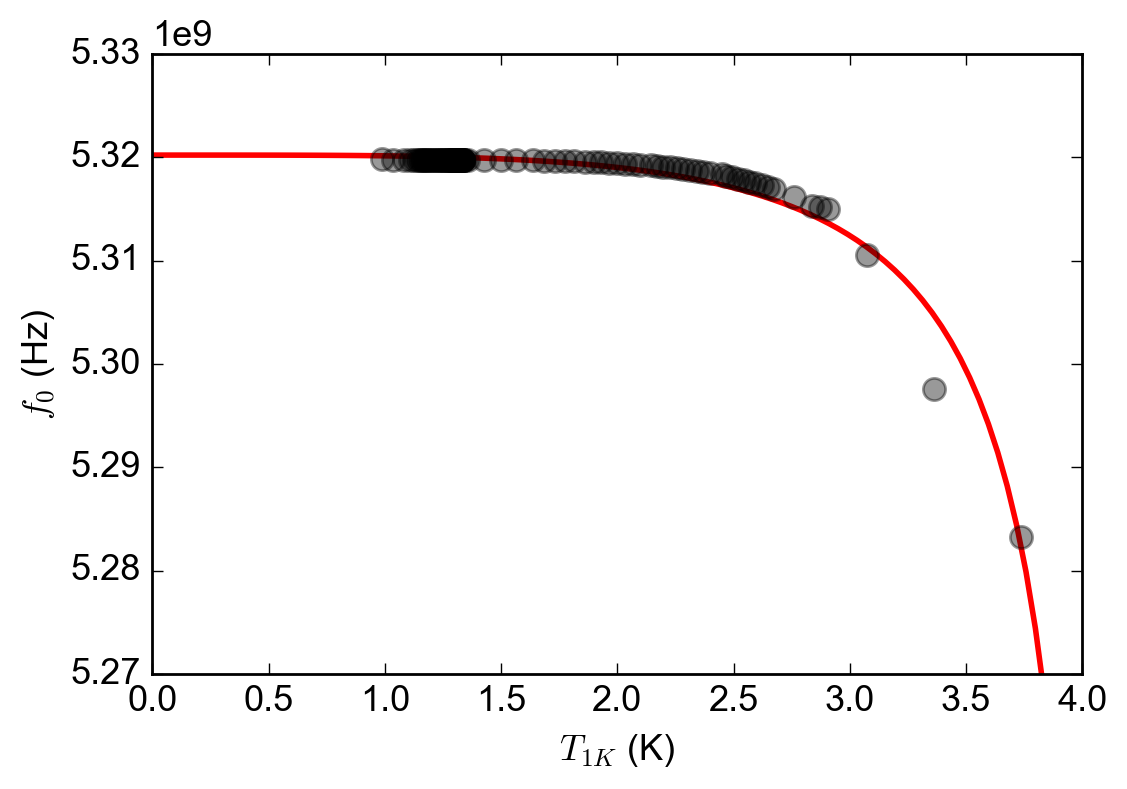

In [129]:
idxs = temperature < 4

fr, ferr = kfit.fit_kinetic_fraction(temperature[idxs], f0s[idxs[:-1]], fitparams=[6E9, 0.001, 4.0])
t = np.linspace(0, 4, 1E2)

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)

plt.plot(t, kfit.kinfunc(t, *fr), '-r', lw=2.0)
plt.plot(temperature[idxs], f0s[idxs[:-1]], 'o', **common.plot_opt('black'))
plt.ylim(5.27E9, 5.33E9)
plt.xlabel(r"$T_{1K}$ (K)")
plt.ylabel(r"$f_0$ (Hz)")

common.save_figure(fig, save_path=os.path.split(fn)[0])

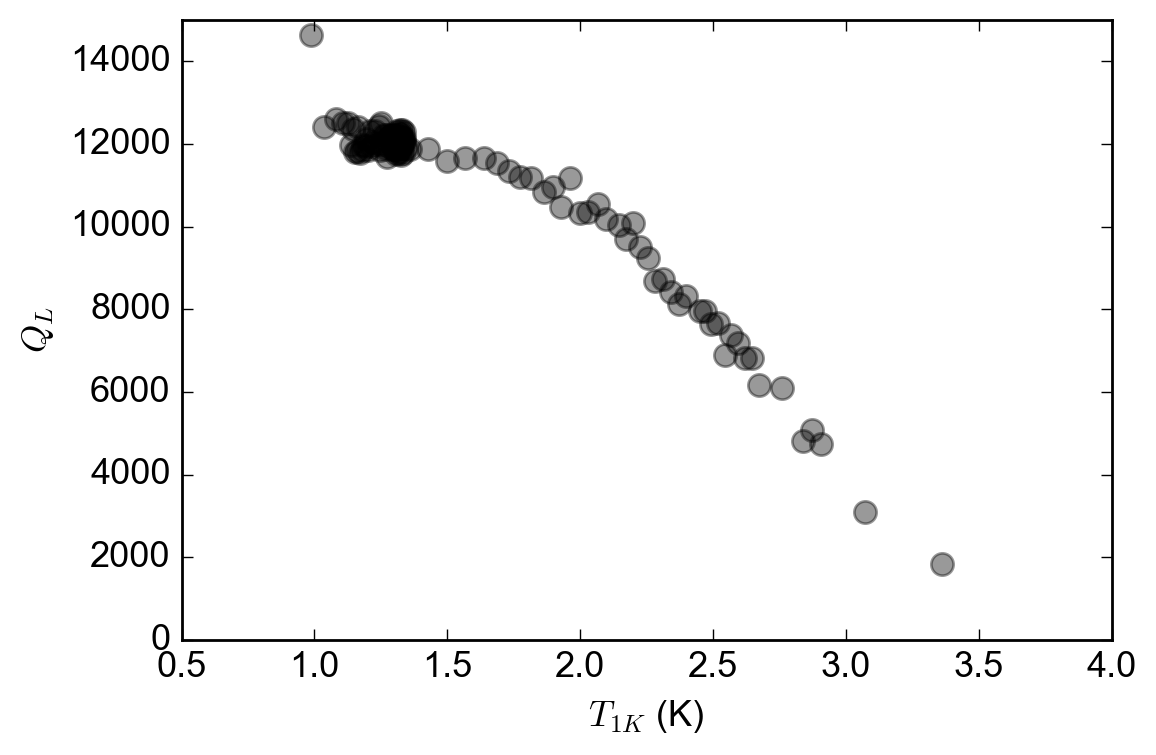

In [130]:
fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)

plt.plot(temperature[idxs], Qs[idxs[:-1]], 'o', **common.plot_opt('black'))
#plt.ylim(5.27E9, 5.33E9)
plt.xlabel(r"$T_{1K}$ (K)")
plt.ylabel(r"$Q_L$")
plt.ylim(0,1.5E4)
#plt.yscale('log')

common.save_figure(fig, save_path=os.path.split(fn)[0])